In [11]:
from network.training_synth_gauss import train_model_and_visualize

gauss_params = {
    'n_samples': 2500,
    'dim': 20,
    'n_clusters': 10,
    'distance_to_center': 5,
    'test_size': 0.25,
    'upper_weight': 1,
    'lower_weight': -1,
    'seed': 564,
    'sigma': None,
    'sparsity': 0.25
}

model = train_model_and_visualize(
    dataset='synthetic',
    gauss_params=gauss_params,
    layers=[20, 30, 10],
    num_epochs=10,
)

 30%|███       | 3/10 [02:15<05:16, 45.25s/it]


KeyboardInterrupt: 

Wir möchten wissen, wie sehr sich die Ground Truth von SynthGauss von den Attribution Scores von IG, BShap und LIME unterscheiden.
Angenommen jeder Datenpunkt hat k viele nicht-null Werte in der GroundTruth G. Wir berechnen dann die top k Attribution Scores jeder Attribution Method und nennen diese Menge M. Wir berechnen dann den Anteil der Elemente in G, die auch in M sind.

In [4]:
from OpenXAI.openxai.dataloader import return_loaders, TabularDataLoader
from attribution import IntegratedGradient
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = TabularDataLoader(
    path="Synthetic",
    filename="test",
    gauss_params=gauss_params,
    label="y",
    scale="minmax")

ig = IntegratedGradient(model)

fraction_ig_arr = []
k_arr = []


for i,x in enumerate(tqdm(dataset.data)):
    binary_mask = torch.tensor(dataset.masks[i])
    x = torch.tensor(x, requires_grad=True).unsqueeze(0)
    ig_score = ig.attribute(x, torch.zeros_like(torch.tensor(x))).squeeze(0)

    k = binary_mask.sum().item()
    k_arr.append(k)
    binary_mask_informative_feature_indices = torch.nonzero(binary_mask).squeeze(1)

    top_k_ig_score_indices = torch.argsort(ig_score, descending=True)[:k]

    intersect_ig = np.intersect1d(binary_mask_informative_feature_indices.numpy(), top_k_ig_score_indices.numpy())
    fraction_ig = len(intersect_ig) / k
    fraction_ig_arr.append(fraction_ig)

pass

  0%|          | 0/6250 [00:00<?, ?it/s]/tmp/ipykernel_127859/1194076344.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ig_score = ig.attribute(x, torch.zeros_like(torch.tensor(x))).squeeze(0)
100%|██████████| 6250/6250 [00:47<00:00, 131.61it/s]


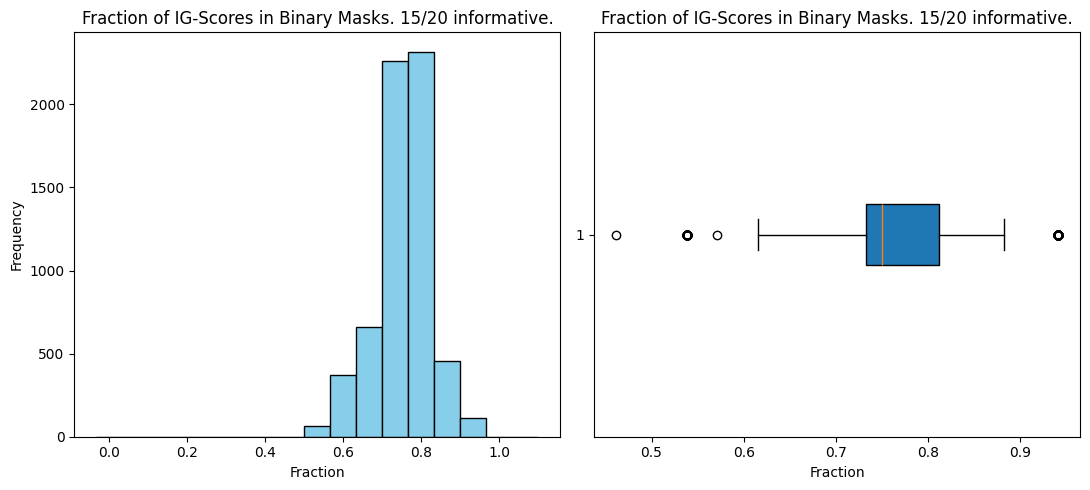

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

k=15

# Plot histogram
ax1.hist(fraction_ig_arr, color='skyblue', edgecolor='black', bins=np.arange(-0.5/k, 1+0.5/k+1/k, 1/k))
ax1.set_title('Fraction of IG-Scores in Binary Masks. 15/20 informative.')
ax1.set_xlabel('Fraction')
ax1.set_ylabel('Frequency')

# Plot boxplot
ax2.boxplot(fraction_ig_arr, vert=False, patch_artist=True)
ax2.set_title('Fraction of IG-Scores in Binary Masks. 15/20 informative.')
ax2.set_xlabel('Fraction')

# Display the plots
plt.tight_layout()
plt.show()

## The following section evaluates the PGI Scores of both the ground truth and IG scores of the SynthGauss dataset.

### Expectation

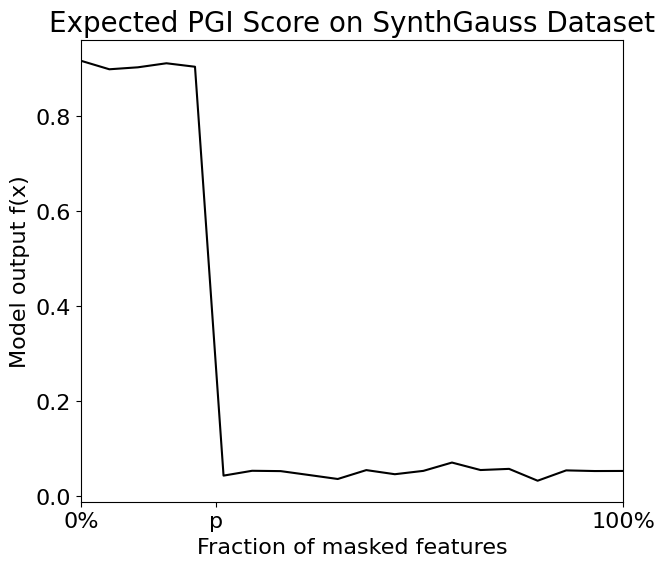

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_features = 20
p_abs = 5

x = np.linspace(0, 1, n_features)

y = np.zeros(n_features)
y[:p_abs] = np.random.normal(0.9, 0.01, p_abs)
y[p_abs:] = np.random.normal(0.05, 0.01, n_features - p_abs)
plt.figure(figsize=(7, 6))
plt.plot(x, y, label="PGI", linestyle='-', color="black")

ticks = [0, p_abs/n_features, 1]
labels = ["0%", "p", "100%"]
plt.xticks(ticks,labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1)
plt.xlabel("Fraction of masked features", fontsize=16)
plt.ylabel("Model output f(x)", fontsize=16)
plt.title("Expected PGI Score on SynthGauss Dataset", fontsize=20)

plt.savefig("SynthGauss_PGI_expected_p0.25.png", dpi=300)


In [ ]:
from OpenXAI.openxai.dataloader import return_loaders, TabularDataLoader

gauss_params = {
    'n_samples': 2500,
    'dim': 20,
    'n_clusters': 10,
    'distance_to_center': 5,
    'test_size': 0.25,
    'upper_weight': 1,
    'lower_weight': -1,
    'seed': 564,
    'sigma': None,
    'sparsity': 0.75
}

dataset = TabularDataLoader(
    path="Synthetic",
    filename="test",
    gauss_params=gauss_params,
    label="y",
    scale="minmax")

print(dataset)

100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


Final metrics: 
Validation-Loss:  0.014
Validation-Accuracy:  91.4%
train-Loss:  0.009
train-Accuracy:  91.6%
# Parameters: 940
NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)


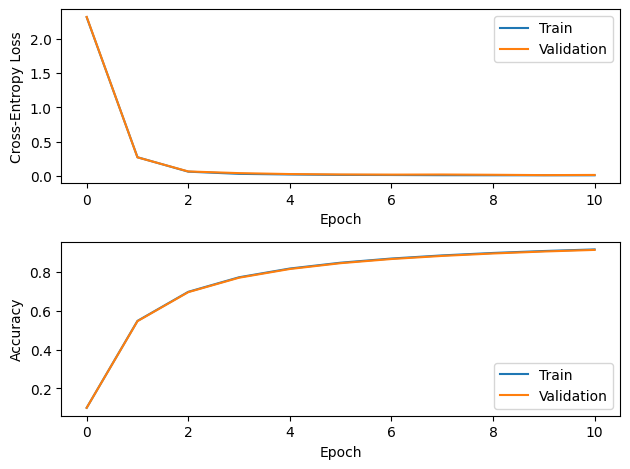

In [ ]:
from network.training_synth_gauss import train_model_and_visualize

model = train_model_and_visualize(
    dataset='synthetic',
    gauss_params=gauss_params,
    layers=[20,30,10],
    num_epochs=10
)

  0%|          | 0/6250 [00:00<?, ?it/s]/home/leon/programming/XAI-baselines/network/models.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(y).detach()
100%|██████████| 6250/6250 [00:12<00:00, 509.16it/s]


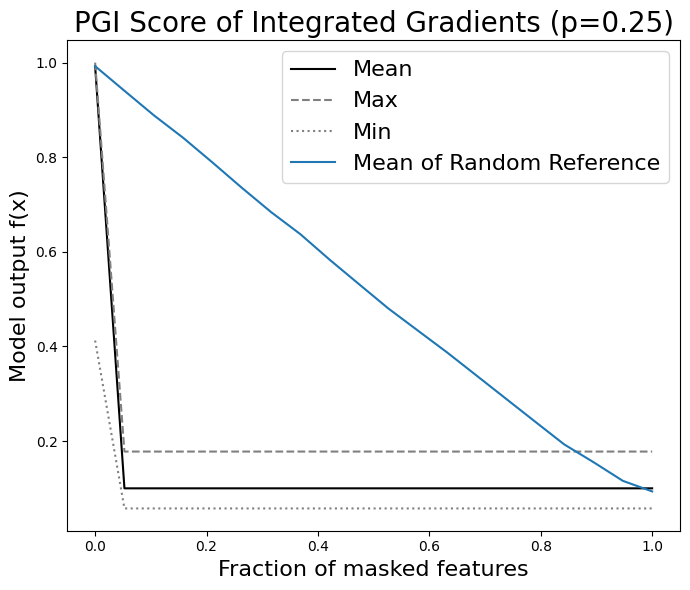

In [ ]:
from evaluation.attribution_methods_evaluator_synth_gauss import AttributionMethodsEvaluator
from captum.attr import IntegratedGradients

am_eval = AttributionMethodsEvaluator(model, gauss_params=gauss_params)

ig = IntegratedGradients(model)
model.eval()

am_eval.visualize_log_odds_of_dataset(
    attribute=ig.attribute,
    title="PGI Score of Integrated Gradients (p=0.25)",
    apply_log=False
)

  0%|          | 0/100 [00:00<?, ?it/s]/home/leon/programming/XAI-baselines/network/models.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(y).detach()
100%|██████████| 6250/6250 [00:11<00:00, 529.27it/s]


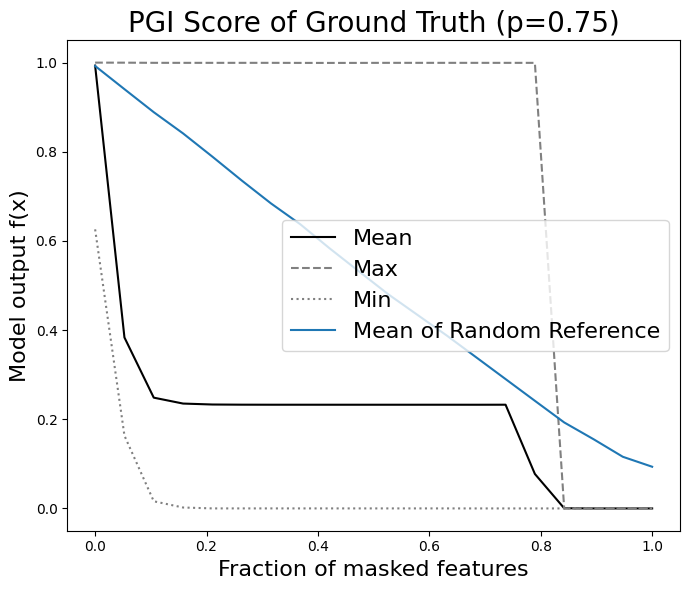

In [ ]:
from evaluation.attribution_methods_evaluator_synth_gauss import AttributionMethodsEvaluator
am_eval = AttributionMethodsEvaluator(model,gauss_params=gauss_params)
am_eval.visualize_log_odds_of_ground_truth_binary_mask(
    title="PGI Score of Ground Truth (p=0.75)",
    apply_log=False,
    num_samples=100
)
